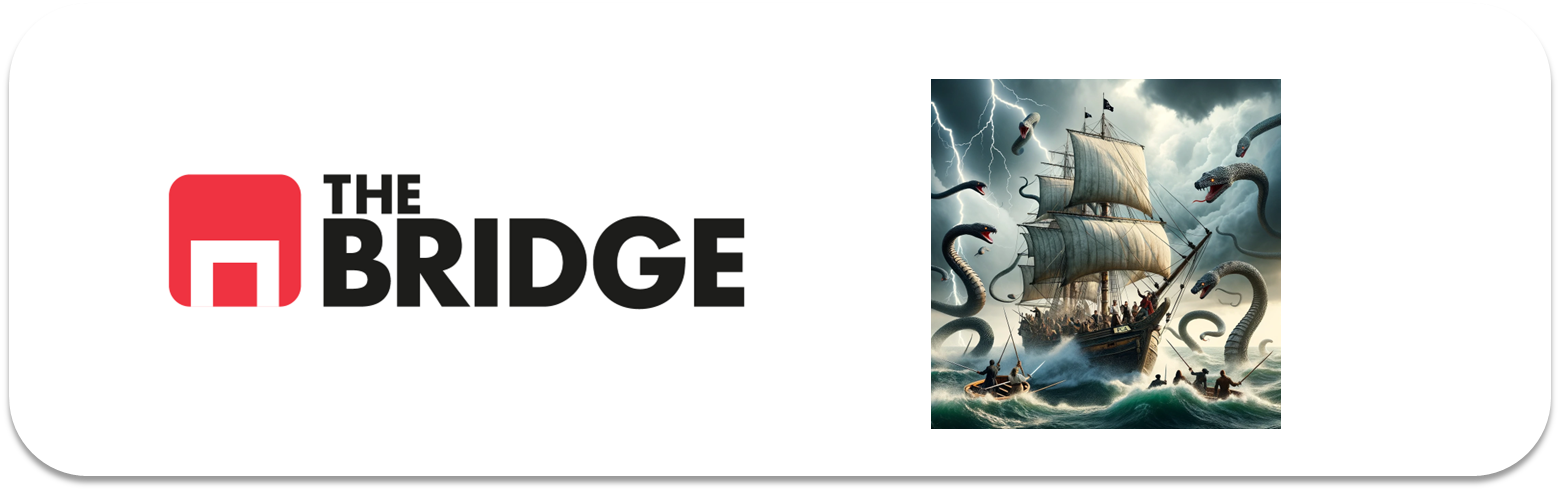

## PRACTICA OBLIGATORIA: **No Supervisado: PCA**

* La práctica obligatoria de esta unidad consiste en aplicar PCA a un dataset de imágenes con diferentes objetivos y compromisos. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### El problema de negocio

El Caesar Palace de las Vegas está planificando la instalación de mil quininetas microcámaras en los accesos a sus instalaciones para las próximas sesiones del "Poker World Championship". Estas microcámaras tienen la peculiaridad de que son capaces de tomar fotos encuadradas de las caras y la desventaja de que no tienen un gran ancho de banda de comunicación. (Las había de más ancho y de mayor precio...). NOTA: El ancho de banda limita el tamaño de las imágenes que pueden enviar las microcámaras).

El objetivo de las microcámaras es el de detectar personas "non-gratas" en tiempo real, pudiendo posprocesar las imágenes para poder detectar si han accedido a las instalaciones personas que estuvieran perseguidas por la ley, en los bancos de datos de los casinos identificadas como "peligrosas" (no se sabe si para el resto de personas o para los beneficios de los casinos) y en las listas de no admisión de jugadores adictos. Por eso no necesitan procesar los datos en tiempo real, pero sí enviarlos a un repositorio central. 

¿Cuál es su problema? O bien comprimen las imágenes y las procesan comprimidas en cada microcámara (pueden comprimir muy rápido pero no tienen cpu para procesarlas sin comprimir) o bien las comprimen y las mandan a un servidor central muy rápido (por eso ti) donde se descomprimirían y se analizarían. Analizar quiere decir en este contexto, pasarles un modelo de clasificación que determine si la persona de la imagen es una de las listas prohibidas (o sea que clasifique la imágen).  

Nos han enviado un dataset y con él debemos estudiar cuál de las dos soluciones es más interesante y dar recomendaciones al respecto. Vamos a ello.

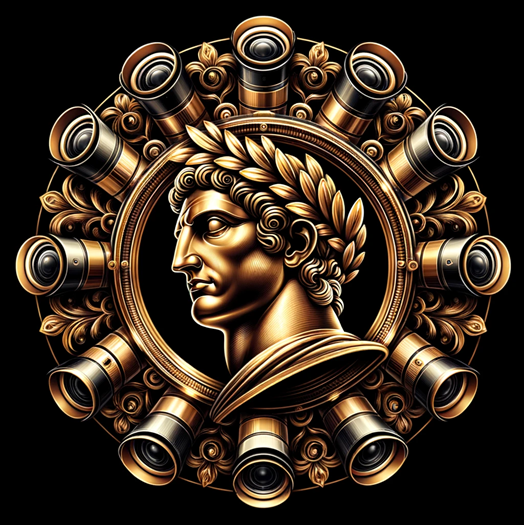

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
# Manipulación de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

# Manejo de imágenes
from sklearn.datasets import fetch_olivetti_faces
from PIL import Image
import os

# Sistema de archivos y warnings
import warnings
warnings.filterwarnings("ignore")

# Configuración de gráficos
plt.style.use("ggplot")
%matplotlib inline


### #1 MODELO DE BASE

**Objetivo:** Construir un modelo baseline de clasficación de imágenes que las trate sin comprimir (es decir usando todos sus píxeles).

Para conseguir el objetivo, primero descarga el dataset de las caras de Olivetti que ya has utilizado anteriormente, empleando las funciones de sklearn necesarias. Luego, construye un clasificador con el modelo que consideres más apropiado y todas las features del dataset. Eso sí, recuerda hacer lo siguiente:

1. Construir un data frame con los datos 
2. Hacer un split en train y test con al menos 80 instancias en el test y estratificado según el target. Este split se ha de mantener en el resto de la práctica
3. Hacer un quick miniEDA o justificar el no hacerlo.
4. Medir la recall media (“balanced_accuracy”) sobre cross validation con 5 folds y sobre el conjunto de test y guarda ambas para usarlas como baseline en las siguientes partes




In [3]:
# 1. Cargar los datos
faces = fetch_olivetti_faces()
X = faces.data  # (400, 4096) cada imagen es de 64x64 = 4096 píxeles
y = faces.target  # 40 personas distintas, 10 imágenes por persona

In [4]:
# 2. Construir DataFrame
df = pd.DataFrame(X)
df["target"] = y

In [6]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669421,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [8]:
# 3. Split train/test (mínimo 80 en test, stratify)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=80, stratify=y, random_state=42
)

In [9]:
# 4. Mini EDA (opcional)
print("Dimensiones:", X.shape)
print("Número de clases:", len(np.unique(y)))
print("Distribución de clases:", np.bincount(y))

Dimensiones: (400, 4096)
Número de clases: 40
Distribución de clases: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]


In [10]:
# 5. Modelo: Logistic Regression (simple, rápida y efectiva con regularización)
model = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr')

In [11]:
# Cross Validation sobre el train
cv_scores = cross_val_score(model, X_train, y_train, scoring="balanced_accuracy", cv=5)
cv_balanced_accuracy = np.mean(cv_scores)

In [12]:
# Entrenar y evaluar en test
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

In [ ]:
print(f"Balanced Accuracy (CV): {cv_balanced_accuracy:.4f}")
print(f"Balanced Accuracy (Test): {test_balanced_accuracy:.4f}")

Balanced Accuracy (CV): 0.9550
Balanced Accuracy (Test): 0.9750


### #2 MODELO PARA LAS MICROCÁMARAS
**Objetivo:** Construir un modelo que pueda funcionar en las microcámaras, es decir que pueda funcionar con datos comprimidos.

Para cumplir con el objetivo se os ocurre emplear la doble propiedad de la PCA, que permite comprimir datos y mantener la capacidad informativa de estos. Sigue los siguientes pasos:
1. Instancia un objeto PCA sobre los datos de Train sin especificar ni componentes ni varianza explicada (o sea sin pasar argumentos).
2. Escoge un rango de valores para el número de PCAs que permitan por lo menos una compresión de la imagen de entre el 0.2% y el 2.5% (prueba al menos 5 valores). NOTA: La compresión es la reducción total, es decir una reducción del 1% quiere decir que el dataset se reduce a un 1% de su tamaño original)
3. Para el rango anterior entrena un modelo de clasificación y apunta su scoring en una validación cruzada de 5 folds y métrica el recall medio y su scoring contra test.
4. Muestra en un dataframe el valor de numero de componentes principales empleado, el scoring en CV, el scoring contra test, el % de compresión, la diferencia con el scoring de CV del modelo base, la diferencia con el scoring en test.
5. Escoge el número de componentes que permitirían tener la mayor compresión con una pérdida inferior a 3 puntos porcentuales tanto en CV como en test. Si no hay escoge el que tenga una pérdida inferior a 5 puntos porcentuales. 

In [14]:
# Ajustamos PCA al train sin limitar componentes
pca_full = PCA()
pca_full.fit(X_train)

# Número de píxeles originales por imagen
n_features = X_train.shape[1]

In [15]:
# Porcentajes deseados de compresión
compression_ratios = [0.002, 0.005, 0.01, 0.015, 0.025]

# Convertimos a número de componentes (mínimo 1)
components_range = [max(1, int(r * n_features)) for r in compression_ratios]
components_range

[8, 20, 40, 61, 102]

In [16]:
results = []

for n_components in components_range:
    # Instanciar y transformar con PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Modelo de clasificación
    model_pca = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr')

    # Cross validation con balanced accuracy
    cv_score = cross_val_score(model_pca, X_train_pca, y_train, scoring="balanced_accuracy", cv=5).mean()

    # Entrenar y evaluar en test
    model_pca.fit(X_train_pca, y_train)
    y_pred_pca = model_pca.predict(X_test_pca)
    test_score = balanced_accuracy_score(y_test, y_pred_pca)

    # Calcular % compresión
    compression = n_components / n_features * 100

    # Diferencias con modelo base
    diff_cv = cv_score - cv_balanced_accuracy
    diff_test = test_score - test_balanced_accuracy

    # Guardar resultados
    results.append({
        "n_components": n_components,
        "compression_%": compression,
        "CV_score": cv_score,
        "Test_score": test_score,
        "Δ_CV_vs_base": diff_cv,
        "Δ_Test_vs_base": diff_test
    })

In [18]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values("compression_%")
df_results.head()

,n_components,compression_%,CV_score,Test_score,Δ_CV_vs_base,Δ_Test_vs_base
0,8,0.195312,0.7400,0.6875,-0.2150,-0.2875
1,20,0.488281,0.9250,0.9000,-0.0300,-0.0750
2,40,0.976562,0.9525,0.9250,-0.0025,-0.0500
3,61,1.489258,0.9600,0.9750,0.0050,0.0000
4,102,2.490234,0.9625,0.9750,0.0075,0.0000


In [19]:
# Filtrar por pérdida aceptable: < 3 puntos
cond3 = (df_results["Δ_CV_vs_base"] >= -0.03) & (df_results["Δ_Test_vs_base"] >= -0.03)
candidatos = df_results[cond3]

if candidatos.empty:
    # Intentamos con pérdida < 5 puntos
    cond5 = (df_results["Δ_CV_vs_base"] >= -0.05) & (df_results["Δ_Test_vs_base"] >= -0.05)
    candidatos = df_results[cond5]

In [20]:
# Escogemos el que más comprime
mejor_opcion = candidatos.sort_values("compression_%").iloc[0] if not candidatos.empty else None

if mejor_opcion is not None:
    print("\nMejor opción (compresión máxima con pérdida <3 o <5 pts):")
    print(mejor_opcion)
else:
    print("❌ No se encontró ninguna configuración que cumpla los criterios.")



Mejor opción (compresión máxima con pérdida <3 o <5 pts):
n_components      61.000000
compression_%      1.489258
CV_score           0.960000
Test_score         0.975000
Δ_CV_vs_base       0.005000
Δ_Test_vs_base     0.000000
Name: 3, dtype: float64


Con solo el 1.48% de los píxeles originales, el modelo mantiene el mismo rendimiento en test y mejor en CV, por lo que el PCA ha comprimido eficientemente sin perder info. 

### #3 COMPRESION PARA CLASIFICACION POSTERIOR

**Objetivo**: Obtener el número de componentes que permita una compresión menor y al tiempo que el modelo en el servidor central no baje su rendimiento respecto a no usar imágenes comprimidas.

Para esta parte la idea que se os ha ocurrido es emplear también la PCA como compresor ya que así siempre podrían pasar a la opción anterior si eso fuese suficiente. Pero en este caso no vamos a utilizar el dataset comprimido con las PCAs para detectar las caras, sino el dataset una vez descomprimido (recuerda que puede emplear `inverse_transform` para "descomprimir"). Los pasos a seguir son:

1. Escoge un rango de valores que  permitan una compresión aún mayor (recuerda que el ancho de banda es mínimo) entre el 1 por mil y el 1 por ciento. Escoge 5 valores de número de PCAs que permitan movernos en ese rango.
2. Para cada uno de esos valores: aplica la PCA al X_train, obten un X_train_unzipped aplicando la inversa de la PCA y entrena un modelo de clasificación y pruébalo contra test, apunta el balanced accuracy.
3. Crea un dataframe o haz un visualización comparando como es la medidad de balance accuracy para cada valor de número de pcas escogido y cuál su factor de compresión. 
4. Sabiendo que no podemos perder más de 3 puntos porcentuales respecto al baseline, ¿qué numero de PCA escogerías?

In [21]:
# Porcentajes aún más bajos: del 0.1% al 1%
compression_ratios_extremos = [0.001, 0.0025, 0.005, 0.0075, 0.01]
components_range_extremos = [max(1, int(r * n_features)) for r in compression_ratios_extremos]
print(components_range_extremos)


[4, 10, 20, 30, 40]


In [22]:
resultados_unzip = []

for n_components in components_range_extremos:
    # PCA y compresión
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Descompresión
    X_train_unzipped = pca.inverse_transform(X_train_pca)
    X_test_unzipped = pca.inverse_transform(X_test_pca)

    # Modelo
    model = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='ovr')
    model.fit(X_train_unzipped, y_train)
    y_pred_unzipped = model.predict(X_test_unzipped)

    # Métrica
    acc = balanced_accuracy_score(y_test, y_pred_unzipped)

    # Guardar
    resultados_unzip.append({
        "n_components": n_components,
        "compression_%": n_components / n_features * 100,
        "Test_score": acc,
        "Δ_Test_vs_base": acc - test_balanced_accuracy
    })


In [23]:
df_unzip = pd.DataFrame(resultados_unzip)
df_unzip = df_unzip.sort_values("compression_%")
df_unzip.head()

,n_components,compression_%,Test_score,Δ_Test_vs_base
0,4,0.097656,0.3875,-0.5875
1,10,0.244141,0.7875,-0.1875
2,20,0.488281,0.9125,-0.0625
3,30,0.732422,0.9375,-0.0375
4,40,0.976562,0.9500,-0.0250


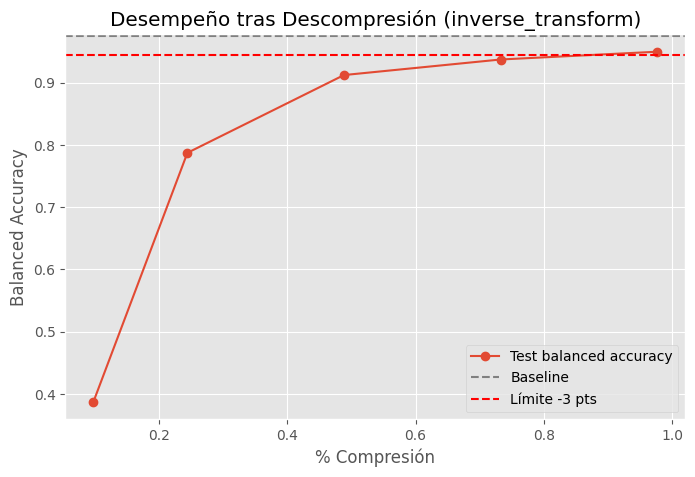

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(df_unzip["compression_%"], df_unzip["Test_score"], marker='o', label="Test balanced accuracy")
plt.axhline(test_balanced_accuracy, color='gray', linestyle='--', label='Baseline')
plt.axhline(test_balanced_accuracy - 0.03, color='red', linestyle='--', label='Límite -3 pts')
plt.xlabel("% Compresión")
plt.ylabel("Balanced Accuracy")
plt.title("Desempeño tras Descompresión (inverse_transform)")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
candidatos_unzip = df_unzip[df_unzip["Δ_Test_vs_base"] >= -0.03]

if not candidatos_unzip.empty:
    mejor_unzipped = candidatos_unzip.sort_values("compression_%").iloc[0]
    print("Mejor configuración que cumple el margen de pérdida < 3 pts:")
    print(mejor_unzipped)
else:
    print("Ninguna configuración cumple el margen de 3 puntos porcentuales.")


Mejor configuración que cumple el margen de pérdida < 3 pts:
n_components      40.000000
compression_%      0.976562
Test_score         0.950000
Δ_Test_vs_base    -0.025000
Name: 4, dtype: float64


Esto reduce el tamaño al original al 0.98%. Sigue clasificando muy bien con solo 2.5 puntos menos y dentro del umbral aceptado. 

### #EXTRA

1. Para la segunda parte, visualiza en cuatro gráficos un scatter plot de las dos primeras componentes principales de la PCA escogida y colorea cada punto con las clases correspondientes a cada cara (como hay 40 clases, usa 10 por gráfico, 1-10 en el primero, 11-20 en el segundo, etc)
2. Para la tercer parte crea una función (modifica la de la práctica de la unidad de KMeans, por ejemplo) que permita ver la cara sin comprimir y la cara después de haberla descomprimido y haz una comprobación de cómo quedan (visualiza 5 caras por ejemplo) para cada uno de los valores de números de PCAs probados. Añade el caso para 150 y 300 PCs para que se vea que son las mismas claras con claridad.

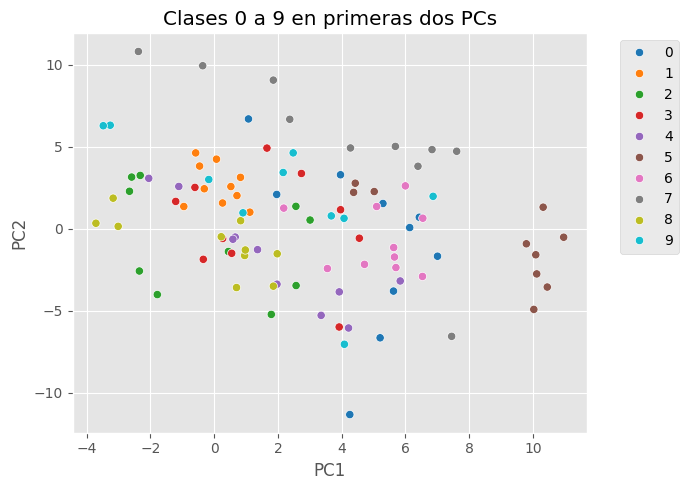

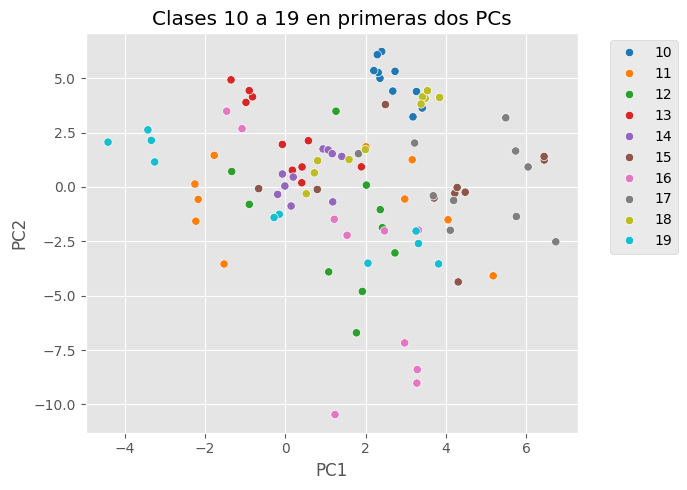

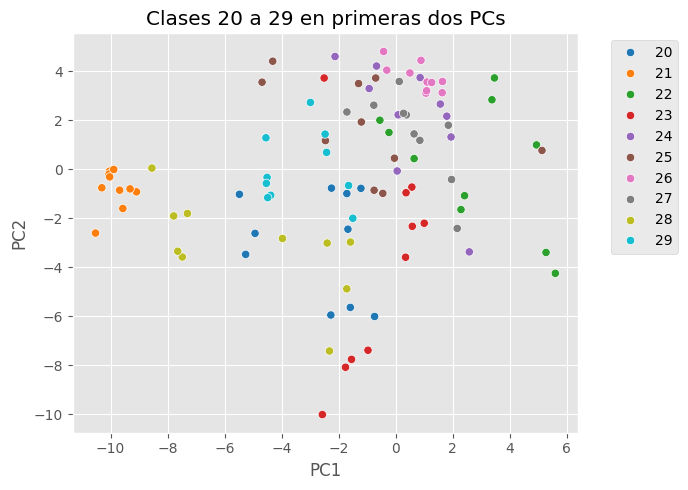

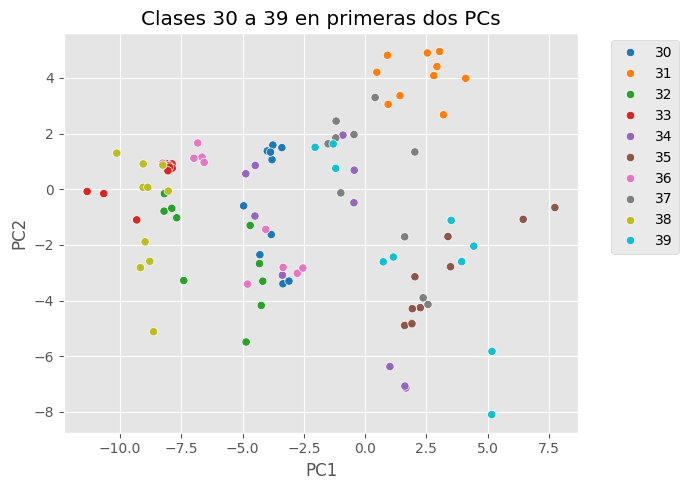

In [26]:
# Usamos la PCA entrenada previamente con 61 componentes
pca_vis = PCA(n_components=2)
X_pca_vis = pca_vis.fit_transform(X)

# Añadimos las PCs y el target al DataFrame
df_pca_vis = pd.DataFrame(X_pca_vis, columns=["PC1", "PC2"])
df_pca_vis["target"] = y

# Graficar por grupos de 10 clases
for i in range(0, 40, 10):
    plt.figure(figsize=(7, 5))
    subset = df_pca_vis[(df_pca_vis["target"] >= i) & (df_pca_vis["target"] < i + 10)]
    sns.scatterplot(data=subset, x="PC1", y="PC2", hue="target", palette="tab10")
    plt.title(f"Clases {i} a {i+9} en primeras dos PCs")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [27]:
def comparar_reconstruccion(X_original, y, pca_list, idx_list, n_components_list):
    """
    X_original: matriz original (400, 4096)
    y: labels (400,)
    pca_list: lista de objetos PCA entrenados
    idx_list: lista de índices de imágenes a mostrar
    n_components_list: número de componentes usados (para el título)
    """
    fig, axes = plt.subplots(len(idx_list), len(pca_list) + 1, figsize=(12, 8))
    for row, idx in enumerate(idx_list):
        # Imagen original
        axes[row, 0].imshow(X_original[idx].reshape(64, 64), cmap="gray")
        axes[row, 0].set_title(f"Original (Clase {y[idx]})")
        axes[row, 0].axis("off")

        for col, (pca, n_comp) in enumerate(zip(pca_list, n_components_list)):
            compressed = pca.transform(X_original[idx].reshape(1, -1))
            reconstructed = pca.inverse_transform(compressed)
            axes[row, col + 1].imshow(reconstructed.reshape(64, 64), cmap="gray")
            axes[row, col + 1].set_title(f"{n_comp} PCs")
            axes[row, col + 1].axis("off")

    plt.tight_layout()
    plt.show()


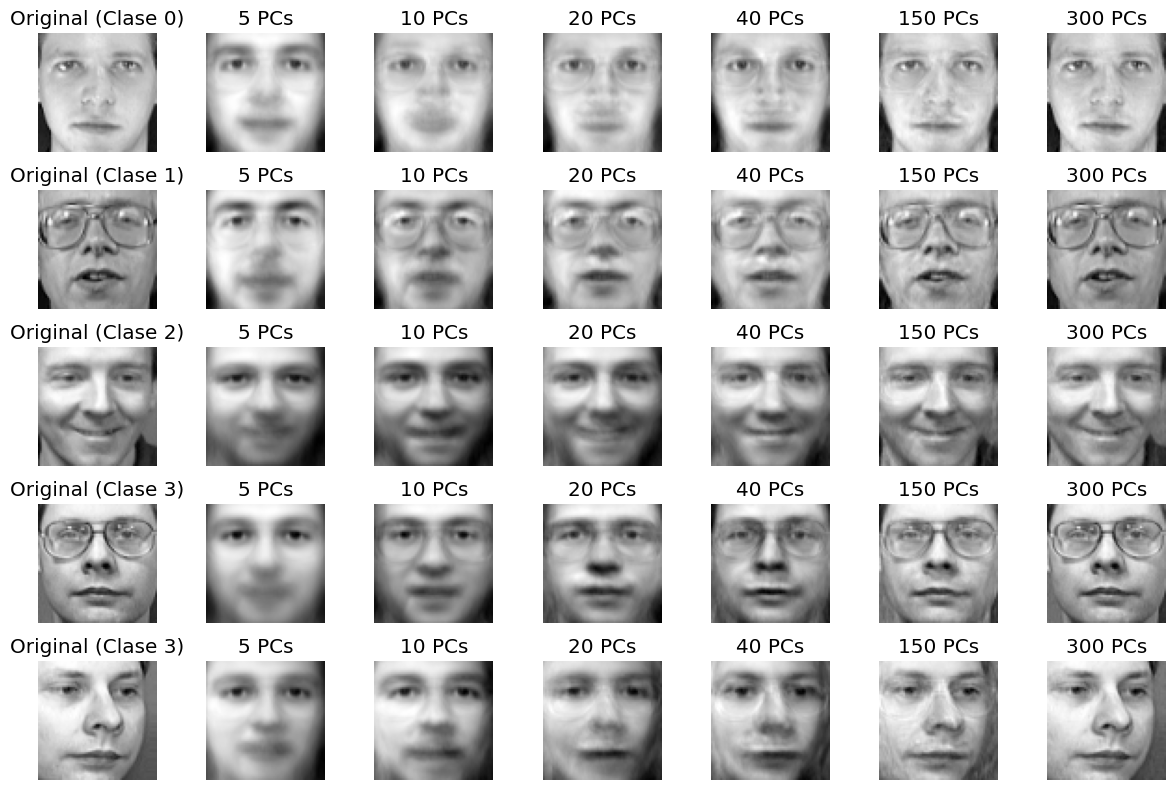

In [28]:
# Entrenamos varios PCA con diferentes compresiones
n_components_list = [5, 10, 20, 40, 150, 300]
pca_list = [PCA(n_components=n).fit(X) for n in n_components_list]

# Mostramos 5 imágenes (por ejemplo, las de las primeras 5 personas)
idx_list = [0, 10, 20, 30, 39]

comparar_reconstruccion(X, y, pca_list, idx_list, n_components_list)